In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [334]:
tops=pd.read_csv(r'D:\jonahtops.csv')
small=tops.head()

In [335]:
n_wells = tops.api.unique().shape[0]
n_formations = tops.formation.unique().shape[0]

print('Number of wells: {}'.format(n_wells))
print('Number of formations: {}'.format(n_formations))
print('Sparsity: {:4.3f}%'.format(float(tops.shape[0]) / float(n_wells*n_formations) * 100))

Number of wells: 2205
Number of formations: 29
Sparsity: 10.315%


In [336]:
formation_to_idx = {}
idx_to_formation = {}
for (idx, formation) in enumerate(tops.formation.unique().tolist()):
    formation_to_idx[formation] = idx
    idx_to_formation[idx] = formation
    
api_to_idx = {}
idx_to_api = {}
for (idx, api) in enumerate(tops.api.unique().tolist()):
    api_to_idx[api] = idx
    idx_to_api[idx] = api

In [337]:
def map_ids(row, mapper):
    return mapper[row]
import scipy.sparse as sparse


In [338]:
#%%timeit
I = tops.api.apply(map_ids, args=[api_to_idx]).as_matrix()
J = tops.formation.apply(map_ids, args=[formation_to_idx]).as_matrix()
V = tops.depth.astype(int)
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

In [339]:
likes

<2205x29 sparse matrix of type '<class 'numpy.float64'>'
	with 6475 stored elements in Compressed Sparse Row format>

In [357]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(likes, k=10)

In [358]:
sigma = np.diag(sigma)

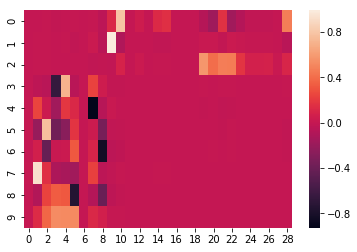

In [359]:
import seaborn as sns

sns.heatmap(Vt)
meandepths=np.mean(likes, axis=1)
likesdemeaned = likes-meandepths.reshape(-1,1)

In [360]:
all_tops= np.dot(np.dot(U, sigma), Vt) + meandepths.reshape(-1,1)

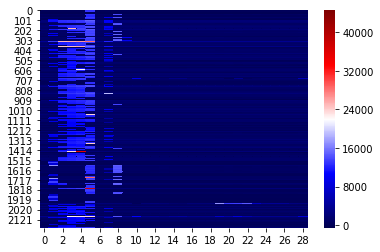

In [361]:
sns.heatmap(all_tops, cmap='seismic')

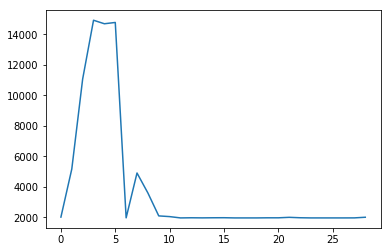

In [345]:
plt.plot(np.ndarray.flatten(np.asarray(all_tops[0])))

In [355]:
all_tops[0,3]

14932.52613496961

In [356]:
tops[tops['api']==3521913]

,api,formation,depth,ssdepth
0,3521913,WASATCH,0,7281
1,3521913,LANCE,9285,-2004
2,3521913,JONAH,11227,-3946
3,3521913,YELLOWPOINT,11793,-4512
4,3521913,WARDELL,12139,-4858
5,3521913,MESAVERDE,12477,-5196


In [349]:
idx_to_formation

{0: 'WASATCH',
 1: 'LANCE',
 2: 'JONAH',
 3: 'YELLOWPOINT',
 4: 'WARDELL',
 5: 'MESAVERDE',
 6: 'LEWIS',
 7: 'FORT UNION',
 8: 'ERICSON',
 9: 'BASE FORT UNION',
 10: 'ROCK SPRINGS',
 11: 'FORT  UNION',
 12: 'ALMOND',
 13: 'LANEC FM',
 14: 'BACON RIDGE',
 15: 'BAXTER',
 16: 'LANE LOWER',
 17: 'LANEY',
 18: 'WILKEN PEAK',
 19: 'FRONTIER',
 20: 'DAKOTA',
 21: 'HILLIARD',
 22: 'MOWRY',
 23: 'MORRISON',
 24: 'BENCH',
 25: 'SHELL CREEK',
 26: 'MUDDY',
 27: 'ASPEN',
 28: 'BLAIR'}

In [244]:
tops.formation.unique()

array(['WASATCH', 'LANCE', 'LANCE - OVER PRESSURE', 'JONAH',
       'YELLOW POINT', 'WARDELL', 'MESAVERDE', nan, 'LEWIS', 'FORT UNION',
       'FORT UNION BASE', 'LANCE UPPER', 'LANCE LOWER', 'ERICSON',
       'FORT UNION TOP', 'BASE FORT UNION', 'UPPER LANCE', 'LOWER LANCE',
       'UPPER MESAVERDE', 'UPPERMESAVERDE', 'TOP OF YELLOW POINT',
       'TERTIARY LAKE', 'MESAVERDE UPPER', 'TD', 'FORT UNION LOWER',
       'FORT UNION UPPER', 'TERTIARY', 'BIOS MARKER', 'BOIS MARKER',
       'B ASE FORT UNION', 'MESVAERDE UPPER', 'LANCE-UPPER',
       'LANCE-LOWER', 'LANCE SH', 'LANCE B', 'LANCE M', 'LANCE TOP UPPER',
       'JONAH TOP', 'YELLOWPOINT TOP', 'WARDELL TOP', 'YELLOWPOINT',
       'LANCE UPPER TOP', 'YELLOW POINT TOP', 'UNNAMED TERTIARY',
       'BOIS MARK', 'BASE FT. UNION', 'LANCE- UPPER', 'MESAVERDE-UPPER',
       'LANCE TOP OF UPPER', 'YELLOW POINT TOP OF', 'LANCE UPPER TOP OF',
       'JONAH TOP OF', 'UNNAMED', 'LANCE SHALE', '1ST LANCE SS',
       'JONAH SS', 'YELLOW POINT SH

In [368]:
import random


In [369]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered 

In [370]:
product_train, product_test, product_users_altered = make_train(likes, pct_test = 0.2)


In [371]:
def implicit_weighted_ALS(training_set, lambda_val = 0.1, alpha = 40, iterations = 10, rank_size = 20, seed = 0):
    '''
    Implicit weighted ALS taken from Hu, Koren, and Volinsky 2008. Designed for alternating least squares and implicit
    feedback based collaborative filtering. 
    
    parameters:
    
    training_set - Our matrix of ratings with shape m x n, where m is the number of users and n is the number of items.
    Should be a sparse csr matrix to save space. 
    
    lambda_val - Used for regularization during alternating least squares. Increasing this value may increase bias
    but decrease variance. Default is 0.1. 
    
    alpha - The parameter associated with the confidence matrix discussed in the paper, where Cui = 1 + alpha*Rui. 
    The paper found a default of 40 most effective. Decreasing this will decrease the variability in confidence between
    various ratings.
    
    iterations - The number of times to alternate between both user feature vector and item feature vector in
    alternating least squares. More iterations will allow better convergence at the cost of increased computation. 
    The authors found 10 iterations was sufficient, but more may be required to converge. 
    
    rank_size - The number of latent features in the user/item feature vectors. The paper recommends varying this 
    between 20-200. Increasing the number of features may overfit but could reduce bias. 
    
    seed - Set the seed for reproducible results
    
    returns:
    
    The feature vectors for users and items. The dot product of these feature vectors should give you the expected 
    "rating" at each point in your original matrix. 
    '''
    
    # first set up our confidence matrix
    
    conf = (alpha*training_set) # To allow the matrix to stay sparse, I will add one later when each row is taken 
                                # and converted to dense. 
    num_user = conf.shape[0]
    num_item = conf.shape[1] # Get the size of our original ratings matrix, m x n
    
    # initialize our X/Y feature vectors randomly with a set seed
    rstate = np.random.RandomState(seed)
    
    X = sparse.csr_matrix(rstate.normal(size = (num_user, rank_size))) # Random numbers in a m x rank shape
    Y = sparse.csr_matrix(rstate.normal(size = (num_item, rank_size))) # Normally this would be rank x n but we can 
                                                                 # transpose at the end. Makes calculation more simple.
    X_eye = sparse.eye(num_user)
    Y_eye = sparse.eye(num_item)
    lambda_eye = lambda_val * sparse.eye(rank_size) # Our regularization term lambda*I. 
    
    # We can compute this before iteration starts. 
    
    # Begin iterations
   
    for iter_step in range(iterations): # Iterate back and forth between solving X given fixed Y and vice versa
        # Compute yTy and xTx at beginning of each iteration to save computing time
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Being iteration to solve for X based on fixed Y
        for u in range(num_user):
            conf_samp = conf[u,:].toarray() # Grab user row from confidence matrix and convert to dense
            pref = conf_samp.copy() 
            pref[pref != 0] = 1 # Create binarized preference vector 
            CuI = sparse.diags(conf_samp, [0]) # Get Cu - I term, don't need to subtract 1 since we never added it 
            yTCuIY = Y.T.dot(CuI).dot(Y) # This is the yT(Cu-I)Y term 
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # This is the yTCuPu term, where we add the eye back in
                                                      # Cu - I + I = Cu
            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu) 
            # Solve for Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, equation 4 from the paper  
        # Begin iteration to solve for Y based on fixed X 
        for i in range(num_item):
            conf_samp = conf[:,i].T.toarray() # transpose to get it in row format and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CiI = sparse.diags(conf_samp, [0]) # Get Ci - I term, don't need to subtract 1 since we never added it
            xTCiIX = X.T.dot(CiI).dot(X) # This is the xT(Cu-I)X term
            xTCiPi = X.T.dot(CiI + X_eye).dot(pref.T) # This is the xTCiPi term
            Y[i] = spsolve(xTx + xTCiIX + lambda_eye, xTCiPi)
            # Solve for Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi, equation 5 from the paper
    # End iterations
    return X, Y.T # Transpose at the end to make up for not being transposed at the beginning. 
                         # Y needs to be rank x n. Keep these as separate matrices for scale reasons. 

In [372]:
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 15, iterations = 1,
                                            rank_size = 20)

In [374]:
user_vecs[0,:].dot(item_vecs).toarray()[0,:]


array([ 1.98532591e-02, -1.39472610e-01,  1.89942321e-01,  1.66561060e-01,
        9.98479152e-01,  9.99111742e-01,  1.38986144e-01,  2.50879939e-01,
       -9.97771594e-02,  1.85124185e-01,  4.85073357e-01,  0.00000000e+00,
        2.55970734e-01,  0.00000000e+00,  1.28134052e-01,  3.75261818e-01,
        3.77790700e-01, -4.22533315e-02, -4.98850566e-02, -2.03945488e-01,
       -1.00082724e-01,  9.50392361e-04,  9.67451947e-02, -1.93473397e-01,
       -1.02385913e-01, -1.02465808e-01,  0.00000000e+00,  1.62603426e-01,
        2.25978215e-01])